## Introduction

Single-cell technologies have revolutionized biology by allowing us to study the transcriptome, epigenome, or proteome of individual cells, rather than averaging over bulk populations. However, single-cell datasets are inherently high-dimensional, sparse, and noisy. Each cell is represented by thousands of features (genes), but many of these features are zero in any given cell due to dropout events. Machine learning (ML) offers powerful tools to handle these challenges: dimensionality reduction, clustering, and predictive modeling can reveal hidden patterns, trajectories, and gene programs in single-cell data.

In this tutorial, we will explore the workflow of analyzing single-cell transcriptomics/multiomics data using ML.

The data is from https://www.10xgenomics.com/datasets/pbmc-from-a-healthy-donor-no-cell-sorting-3-k-1-standard-2-0-0, containing the PBMC 3k of ATAC and expression. We first import the packages and load the cell * gene matrix.

In [56]:
import pandas as pd
import numpy as np
import pyranges as pr
import scanpy as sc
import scipy.sparse as sp
from scipy.sparse import coo_matrix

### 1. Annotated data and its property

In [57]:
# Load the annotated data from the h5 file
h5_file = "data_singlecell/pbmc_unsorted_3k_filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(h5_file)
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 3009 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'


/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [45]:
# Check the sparsity of the annotated data
print(adata.X)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 4759280 stored elements and shape (3009, 36601)>
  Coords	Values
  (0, 24)	1.0
  (0, 62)	2.0
  (0, 99)	1.0
  (0, 168)	1.0
  (0, 216)	2.0
  (0, 278)	1.0
  (0, 298)	1.0
  (0, 350)	1.0
  (0, 355)	2.0
  (0, 356)	1.0
  (0, 359)	2.0
  (0, 431)	1.0
  (0, 524)	4.0
  (0, 525)	1.0
  (0, 535)	1.0
  (0, 550)	1.0
  (0, 559)	1.0
  (0, 565)	1.0
  (0, 571)	2.0
  (0, 604)	1.0
  (0, 645)	2.0
  (0, 662)	1.0
  (0, 666)	1.0
  (0, 708)	1.0
  (0, 819)	1.0
  :	:
  (3008, 36076)	1.0
  (3008, 36078)	1.0
  (3008, 36091)	2.0
  (3008, 36103)	1.0
  (3008, 36136)	3.0
  (3008, 36170)	1.0
  (3008, 36172)	1.0
  (3008, 36194)	1.0
  (3008, 36248)	2.0
  (3008, 36300)	1.0
  (3008, 36317)	1.0
  (3008, 36386)	1.0
  (3008, 36401)	1.0
  (3008, 36559)	29.0
  (3008, 36560)	24.0
  (3008, 36561)	79.0
  (3008, 36562)	143.0
  (3008, 36563)	5.0
  (3008, 36564)	98.0
  (3008, 36565)	138.0
  (3008, 36566)	107.0
  (3008, 36567)	7.0
  (3008, 36568)	61.0
  (3008, 36569)	33.0
  (

In [46]:
# Check the cell and gene metadata

print(adata.obs)
print(adata.var)

Empty DataFrame
Columns: []
Index: [AAACAGCCAACAGGTG-1, AAACATGCAACAACAA-1, AAACATGCACCTGGTG-1, AAACCAACACAGCCTG-1, AAACCAACAGCAAGAT-1, AAACCAACATTGCGAC-1, AAACCGAAGCACAGCC-1, AAACCGCGTAATTAGC-1, AAACCGCGTCACGAAC-1, AAACCGGCAGAGGGAG-1, AAACCGGCAGGGAGGA-1, AAACCGGCATAAAGCA-1, AAACCGGCATGAGCAG-1, AAACGCGCACACTAAT-1, AAACGCGCACCAACCG-1, AAACGCGCATAGTCAT-1, AAACGCGCATTCAGCA-1, AAACGGATCAGCACCA-1, AAACGTACAACAGGAT-1, AAACGTACATTCAGCA-1, AAAGCACCATGTCAGC-1, AAAGCCCGTATTGCAG-1, AAAGCCCGTGATTTGG-1, AAAGCCGCATAGCAGG-1, AAAGCGGGTCCGGTTC-1, AAAGCTTGTACTTCAC-1, AAAGCTTGTAGGTTTG-1, AAAGCTTGTGCATCGG-1, AAAGCTTGTTTGCAGA-1, AAAGGACGTGTAATAC-1, AAAGGACGTTATAGCG-1, AAAGGAGCAAACGCGA-1, AAAGGAGCAACAGGAT-1, AAAGGAGCAGTAGGAT-1, AAAGGAGCATTAGCCA-1, AAAGGCTCACAATGCC-1, AAAGGTTAGCAAGACA-1, AAATCCGGTATTTGGG-1, AAATCCGGTGCACGCA-1, AAATGCCTCCTTCAAT-1, AAATGGCCAATAGCAA-1, AAATGGCCAATAGTCT-1, AAATGGCCATTATGAC-1, AACAAAGGTATTGGTG-1, AACAAGCCAATAATGG-1, AACAAGCCACGTGCTG-1, AACAGATAGCAAACCT-1, AACAGCAAGAGAGGCT-1, AACA

### 2. ATAC data

Then we load the ATAC data.

In [5]:
import pandas as pd
import pyranges as pr

# Read fragments
fragments = pd.read_csv(
    "data_singlecell/pbmc_unsorted_3k_atac_fragments.tsv.gz.tsv",
    sep='\t',
    header=None,
    names=['chrom','start','end','barcode','count','strand'],
    compression='gzip',
    comment='#'
)

# Filter for RNA cells
cell_barcodes = set(adata.obs_names)
fragments = fragments[fragments['barcode'].isin(cell_barcodes)]

# Rename columns for PyRanges
fragments = fragments.rename(columns={
    'chrom': 'Chromosome',
    'start': 'Start',
    'end': 'End',
    'strand': 'Strand'  # optional
})

# Create PyRanges object
fr = pr.PyRanges(fragments[['Chromosome','Start','End','barcode','count','Strand']])

In [6]:
# Read peaks BED, skipping comment lines
peaks = pd.read_csv(
    "data_singlecell/pbmc_unsorted_3k_atac_peaks.bed",
    sep='\t',
    header=None,
    names=['chrom','start','end'],
    comment='#'   # <-- skip any lines starting with #
)

# Rename columns for PyRanges
peaks = peaks.rename(columns={
    'chrom': 'Chromosome',
    'start': 'Start',
    'end': 'End'
})

# Now create PyRanges object
pk = pr.PyRanges(peaks)
overlaps = fr.join(pk)

In [7]:
# Assign peak indices
peaks_df = pk.df.reset_index(drop=True)
peaks_df['peak_idx'] = np.arange(len(peaks_df))

# Merge overlaps with peak indices
overlaps_df = overlaps.df.merge(
    peaks_df[['Chromosome','Start','End','peak_idx']],
    left_on=['Chromosome','Start_b','End_b'],  
    right_on=['Chromosome','Start','End'],
    how='left'
)

# Map barcodes to RNA cell indices
cell_to_idx = {cell:i for i, cell in enumerate(adata.obs_names)}
overlaps_df['cell_idx'] = overlaps_df['barcode'].map(cell_to_idx)

# Build sparse matrix
from scipy.sparse import coo_matrix

rows = overlaps_df['cell_idx'].to_numpy()
cols = overlaps_df['peak_idx'].to_numpy()
data = overlaps_df['count'].to_numpy()

X_atac = coo_matrix((data, (rows, cols)), shape=(adata.n_obs, len(peaks_df)))


In [8]:
X_atac.shape

(3009, 81156)

In [9]:
import scipy.sparse as sp
import scanpy as sc
atac_adata = sc.AnnData(X=X_atac, obs=adata.obs.copy(), var=peaks)

/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [58]:
atac_adata.shape, adata.shape

((3009, 79847), (3009, 36601))

### 3. Single-cell expression analysis

/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/functools.py:889: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/3t/pvgbrjnn5m56z9knqqqkn9900000gn/T/ipykernel_69963/1629625581.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


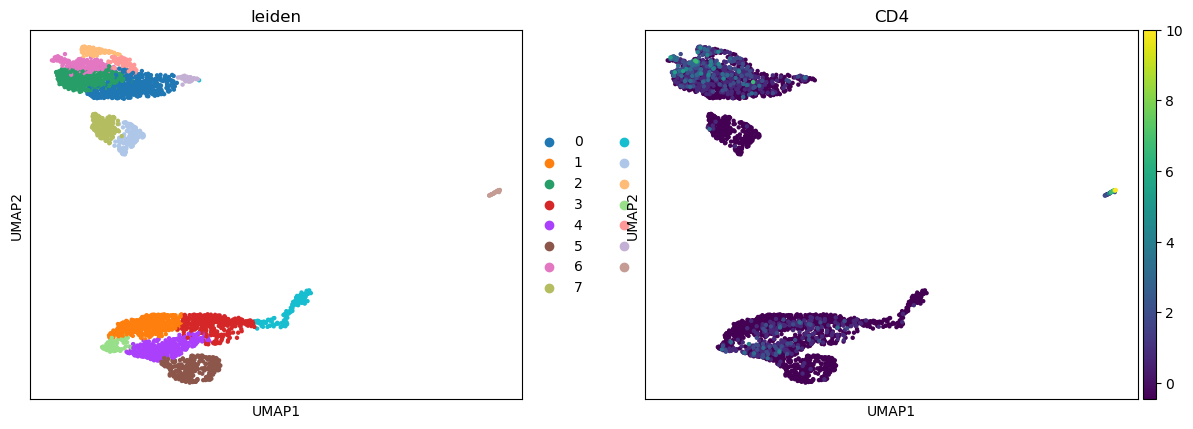

In [11]:
# Scale data
sc.pp.scale(adata, max_value=10)

# PCA
sc.tl.pca(adata, svd_solver='arpack')

# Clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)

# Visualization
sc.tl.umap(adata)
sc.pl.umap(adata, color=['leiden', 'CD4'])

/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-pac

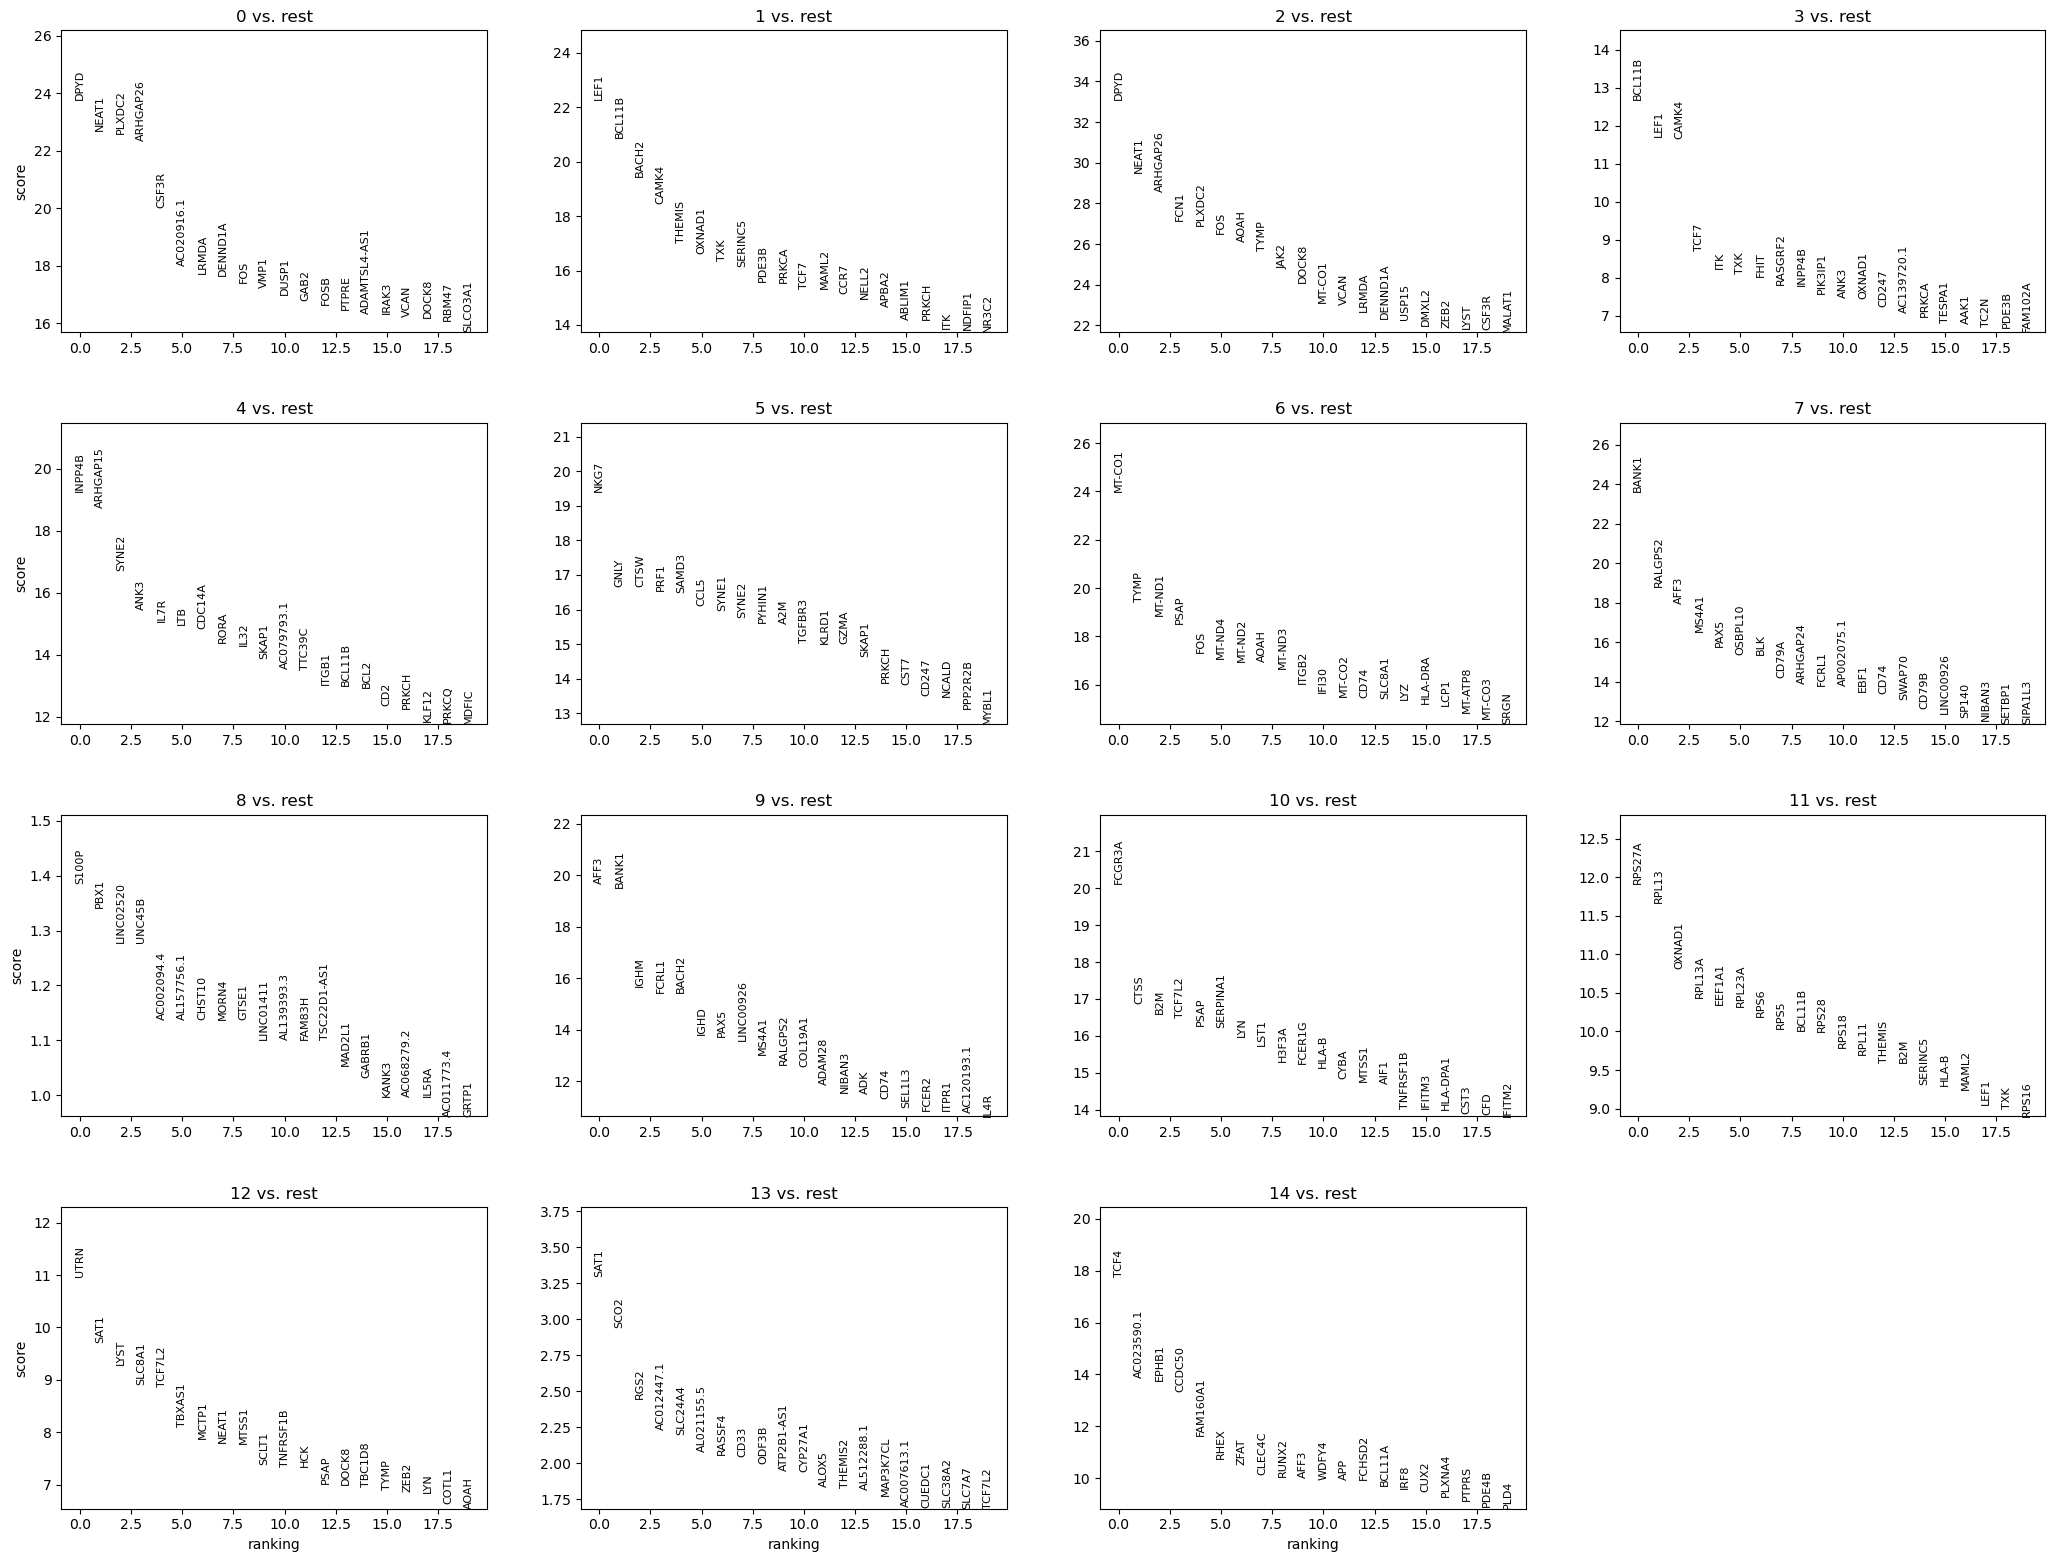

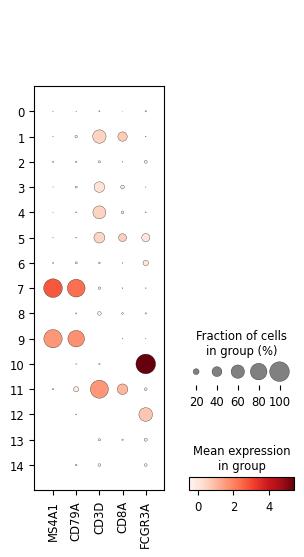

In [12]:
# Find marker genes for each cluster
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

# Visualize specific markers
marker_genes = ['MS4A1', 'CD79A', 'CD3D', 'CD8A', 'FCGR3A']
sc.pl.dotplot(adata, marker_genes, groupby='leiden')

/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/homebrew/Caskroom/miniconda/base/envs/BioML-tut-llm/lib/python3.10/site-pac

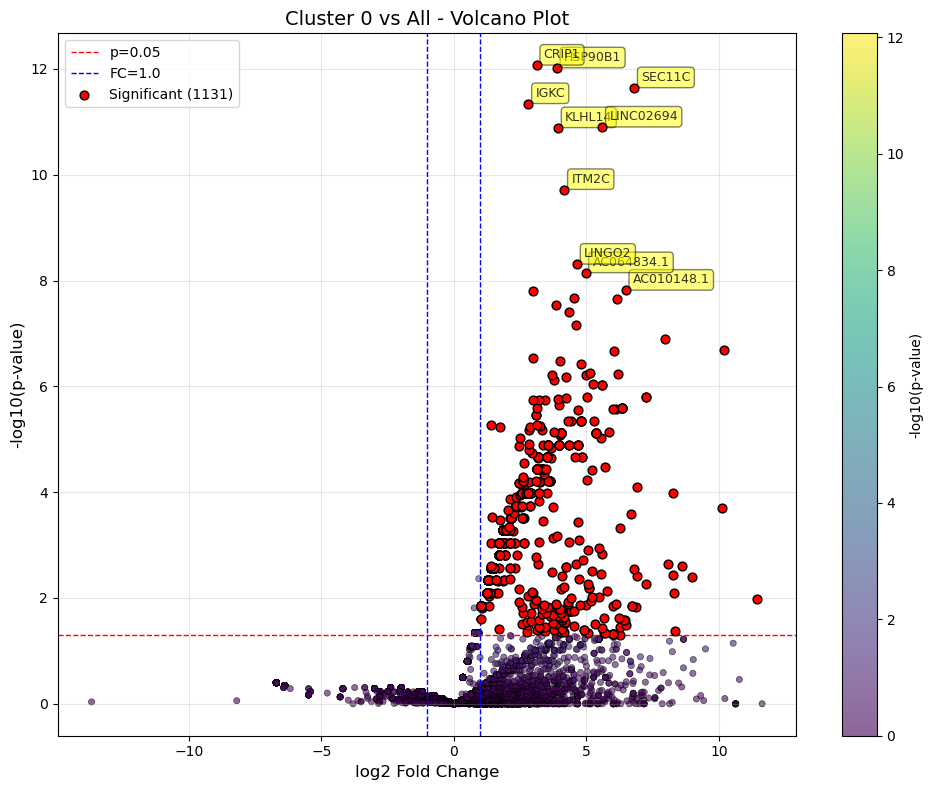

In [13]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. First perform differential expression analysis
sc.tl.rank_genes_groups(
    adata, 
    groupby='leiden',  # or any grouping (cell_type, condition, etc.)
    method='t-test',   # or 'wilcoxon', 'logreg'
    use_raw=False
)

# 2. Extract results for a specific group (e.g., cluster 0 vs all)
result = sc.get.rank_genes_groups_df(adata, group='0')

# 3. Create volcano plot
def volcano_plot_from_scanpy(result_df, title="Volcano Plot"):
    """
    Create volcano plot from Scanpy differential expression results
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Extract values
    log2fc = result_df['logfoldchanges']
    pvals = result_df['pvals']
    genes = result_df['names']
    
    # Calculate -log10(p-value)
    neg_log10_pvals = -np.log10(pvals)
    
    # Create scatter plot
    scatter = ax.scatter(
        log2fc, 
        neg_log10_pvals,
        s=20,          # Point size
        alpha=0.6,
        c=neg_log10_pvals,  # Color by significance
        cmap='viridis',
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add significance thresholds (commonly used)
    pval_threshold = 0.05
    fc_threshold = 1.0  # 2-fold change
    
    # Horizontal line for p-value threshold
    ax.axhline(
        y=-np.log10(pval_threshold), 
        color='red', 
        linestyle='--', 
        linewidth=1,
        label=f'p={pval_threshold}'
    )
    
    # Vertical lines for fold change thresholds
    ax.axvline(
        x=fc_threshold, 
        color='blue', 
        linestyle='--', 
        linewidth=1,
        label=f'FC={fc_threshold}'
    )
    ax.axvline(
        x=-fc_threshold, 
        color='blue', 
        linestyle='--', 
        linewidth=1
    )
    
    # Highlight significant genes
    significant = (pvals < pval_threshold) & (np.abs(log2fc) > fc_threshold)
    if significant.any():
        sig_genes = genes[significant]
        sig_log2fc = log2fc[significant]
        sig_pvals = neg_log10_pvals[significant]
        
        # Plot significant points in red
        ax.scatter(
            sig_log2fc, 
            sig_pvals,
            s=40,
            c='red',
            edgecolors='black',
            linewidth=1,
            label=f'Significant ({significant.sum()})',
            zorder=10
        )
        
        # Label top significant genes
        top_n = min(10, len(sig_genes))
        top_indices = np.argsort(sig_pvals)[-top_n:]  # Top by significance
        
        for idx in top_indices:
            ax.annotate(
                sig_genes.iloc[idx],
                xy=(sig_log2fc.iloc[idx], sig_pvals.iloc[idx]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9,
                alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5)
            )
    
    # Labels and title
    ax.set_xlabel('log2 Fold Change', fontsize=12)
    ax.set_ylabel('-log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(scatter, ax=ax, label='-log10(p-value)')
    plt.tight_layout()
    return fig, ax, significant

# Create volcano plot
fig, ax, significant = volcano_plot_from_scanpy(
    result, 
    title="Cluster 0 vs All - Volcano Plot"
)
plt.show()